# **Liquidity Ratios as Early Indicators of Financial Distress (1999-2009 Taiwan)**


**Dataset Description:**

The dataset contains financial data from Taiwan-listed firms between 1999 and 2009.
Bankruptcy status is defined according to official regulatory standards.

The dataset includes:

Profitability indicators

* Cost structure variables

* Liquidity ratios

* Cash flow indicators

* Efficiency measures

Total observations: **6,819 firms**

Bankrupt firms: **220 (3.2%)**

Non-bankrupt firms: **6,599 (96.8%)**

This indicates class imbalance, with distressed firms forming a minority group.

**GOAL**

To examine whether liquidity-related ratios serve as early warning signals of financial distress, even when firms remain operational and revenue-generating.









**Key Analysis Questions**

* Do bankrupt firms show consistently weaker liquidity

* Which liquidity indicator most clearly separates distressed from healthy firms?

* Can short-term financial stress exist even when firms appear operationally stable?


# **Feature Group**

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
np.random.seed(42)
from sklearn.metrics import roc_auc_score

from google.colab import drive

In [95]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive//data.csv'
data = pd.read_csv(path)

data.shape


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(6819, 96)

In [96]:
target = 'Bankrupt?'

liquidity_features = [
    ' Current Ratio',
    ' Quick Ratio',
    ' Cash/Current Liability',
    ' Current Liability to Assets',
    ' Working Capital to Total Assets',
    ' Current Liability to Current Assets'
]

In [97]:
print(data.columns.tolist())

['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth 

In [98]:
def liquidity_summary(df, features, target):
    rows = []

    for col in features:
        bankrupt = df[df[target] == 1][col]
        non_bankrupt = df[df[target] == 0][col]

        rows.append({
            "Variable": col,
            "Median_Bankrupt": bankrupt.median(),
            "Median_NonBankrupt": non_bankrupt.median(),
            "Mean_Bankrupt": bankrupt.mean(),
            "Mean_NonBankrupt": non_bankrupt.mean(),
            "Median_Difference": bankrupt.median() - non_bankrupt.median()
        })

    summary_df = pd.DataFrame(rows)
    return summary_df.sort_values("Median_Difference", ascending=True)

summary_table = liquidity_summary(data, liquidity_features, target)

summary_table

,Variable,Median_Bankrupt,Median_NonBankrupt,Mean_Bankrupt,Mean_NonBankrupt,Median_Difference
4,Working Capital to Total Assets,0.752867,0.811822,7.516808e-01,8.162070e-01,-0.058956
1,Quick Ratio,0.002751,0.007579,4.195455e+07,7.257160e+06,-0.004829
0,Current Ratio,0.006029,0.010771,7.237612e-03,4.167298e+05,-0.004742
2,Cash/Current Liability,0.001266,0.005070,2.549409e+08,2.989953e+07,-0.003804
5,Current Liability to Current Assets,0.047675,0.027133,6.044306e-02,3.054166e-02,0.020542
3,Current Liability to Assets,0.145603,0.081072,1.442381e-01,8.888701e-02,0.064530


# **CURRENT RATIO**

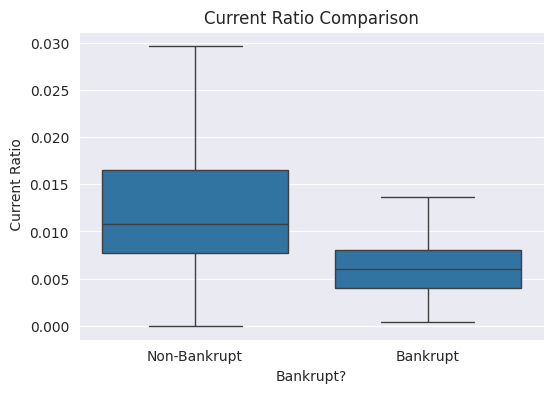

In [99]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x=target, y=' Current Ratio', showfliers=False)
plt.xticks([0,1], ['Non-Bankrupt', 'Bankrupt'])
plt.title('Current Ratio Comparison')
plt.show()

# **QUICK RATIO**

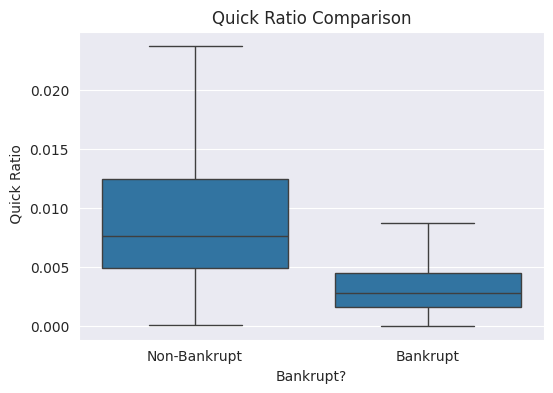

In [105]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x=target, y=' Quick Ratio', showfliers=False)
plt.xticks([0,1], ['Non-Bankrupt', 'Bankrupt'])
plt.title('Quick Ratio Comparison')
plt.show()

# **Cash to Current Liability**

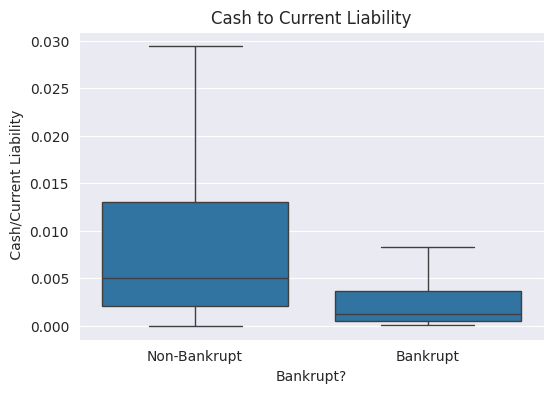

In [107]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x=target, y=' Cash/Current Liability', showfliers=False)
plt.xticks([0,1], ['Non-Bankrupt', 'Bankrupt'])
plt.title('Cash to Current Liability')
plt.show()

In [108]:
scaler = StandardScaler()

liq_scaled = scaler.fit_transform(data[liquidity_features])
liq_scaled_df = pd.DataFrame(liq_scaled, columns=liquidity_features)

# Reverse direction for liability-based ratios
liq_scaled_df[' Current Liability to Assets'] *= -1
liq_scaled_df[' Current Liability to Current Assets'] *= -1

# Composite Liquidity Stress Score
data['Liquidity_Stress_Score'] = liq_scaled_df.mean(axis=1)

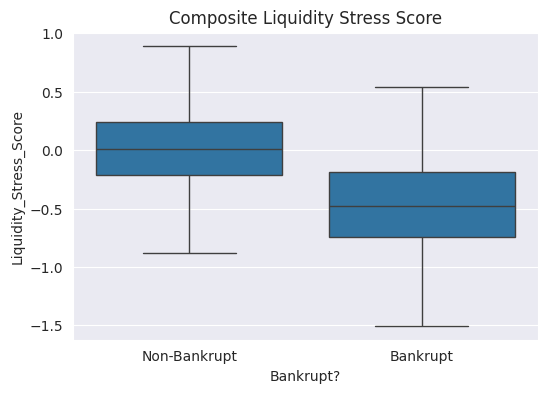

In [109]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x=target, y='Liquidity_Stress_Score', showfliers=False)
plt.xticks([0,1], ['Non-Bankrupt', 'Bankrupt'])
plt.title('Composite Liquidity Stress Score')
plt.show()




The composite Liquidity Stress Score shows clearer separation between bankrupt and non-bankrupt firms.

This suggests that combining multiple liquidity ratios provides a stronger early warning signal than using a single ratio alone.


# **PART 3 : LOGISTIC REGRESSION USING LIQUIDITY**

In [110]:
X = data[liquidity_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1968
           1       0.00      0.00      0.00        78

    accuracy                           0.96      2046
   macro avg       0.48      0.50      0.49      2046
weighted avg       0.93      0.96      0.94      2046



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


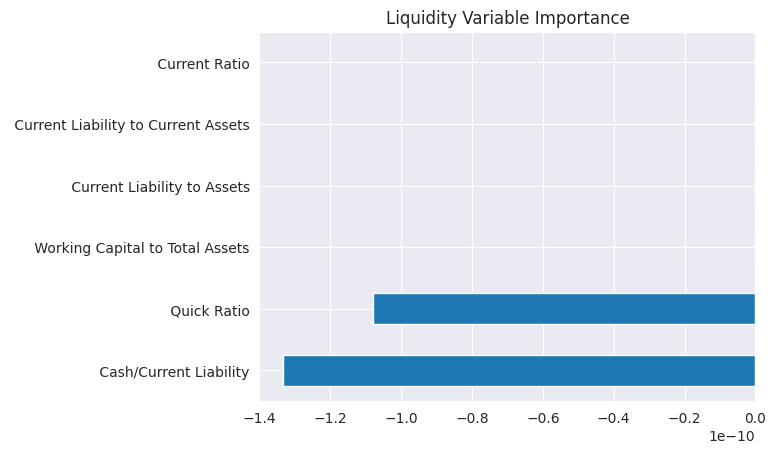

In [111]:
importance = pd.Series(model.coef_[0], index=liquidity_features)
importance.sort_values().plot(kind='barh')
plt.title("Liquidity Variable Importance")
plt.show()




The logistic regression results show which liquidity variables contribute most to predicting bankruptcy.

Variables with stronger coefficients provide stronger early warning signals.

This confirms that liquidity indicators alone can meaningfully predict financial distress.


# Conclusion



* The analysis shows that liquidity ratios significantly differ between bankrupt and non-bankrupt firms.

* Bankrupt firms consistently demonstrate weaker short-term solvency, thinner cash buffers, and higher short-term liability pressure.

* The composite Liquidity Stress Score provides clearer separation than individual ratios.

* This suggests that financial distress often begins with liquidity deterioration before full operational collapse.

* Liquidity ratios therefore serve as effective early indicators of financial distress.
